In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def f(x: float):
    return x**2 - x + 1

xs = np.linspace(-1, 1, 10)
ys = f(xs)

plt.plot(xs, ys)

In [ ]:
def der(x: float, f):
    delta = 0.000001
    return (f(x+delta) - f(x-delta)) / (2*delta)

print(der(-0.5, f))

In [ ]:
class fn:
    def __init__(self, a, b, c) -> None:
        self.a = a
        self.b = b
        self.c = c
    def d(self, a=None, b=None, c=None):
        if a is None:
            a = self.a
        if b is None:
            b = self.b
        if c is None:
            c = self.c
        d = a*b + c
        return d

a = 2.0
b = -3.0
c = 13.0
d = a*b + c

delta = 0.0001
func = fn(a, b, c)
ddda_a = (func.d(a=a+delta) - func.d(a=a-delta)) / (2*delta)
ddda_b = (func.d(b=b+delta) - func.d(b=b-delta)) / (2*delta)
ddda_c = (func.d(c=c+delta) - func.d(c=c-delta)) / (2*delta)

ddda_a, ddda_b, ddda_c

In [12]:
%load_ext autoreload
%autoreload 2
from helper import draw_dot

class Value:
    def __init__(self, data, _children=(), _op='', label='') -> None:
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, _children=(self, other), _op='+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
            # self._backward()
            # other._backward()
        out._backward = _backward
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, _children=(self, other), _op='*')
        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
            # self._backward()
            # other._backward()
        out._backward = _backward
        return out
    
    def tanh(self): 
        ex = math.exp(2*self.data)
        out = Value((ex - 1)/(ex + 1), _children=(self,), _op='tanh')
        def _backward(): 
            self.grad += (1 - out.data ** 2) * out.grad
            # self._backward()
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
            return
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:

# alpha = 0.01
# for i in range(20):
#     a.data += alpha * a.grad
#     b.data += alpha * b.grad
#     c.data += alpha * c.grad
#     f.data += alpha * f.grad

#     e = a*b; e.label = 'e'
#     d = e + c; d.label = 'd'
#     L = d * f; L.label = 'L'

#     # print(L)


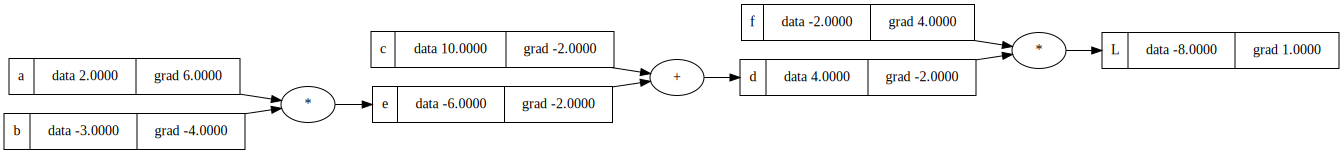

In [9]:
"""

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'

"""

L.grad = 1
f.grad = d.data
d.grad = f.data
c.grad = f.data
e.grad = f.data
a.grad = f.data * b.data
b.grad = f.data * a.data

draw_dot(L)

In [10]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w1
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.88137, label='b')

w1x1 = w1 * x1; w1x1.label = "w1*x1"
w2x2 = w2 * x2; w2x2.label = "w2*x2"
w1x1w2x2 = w1x1 + w2x2; w1x1w2x2.label = "w1*x1 + w2*x2"
z = w1x1w2x2 + b; z.label = "z"
a = z.tanh(); a.label = "a"

# h = 0.0000000001
# z2 = w1x1w2x2 + b
# z2.data += h 
# a2 = z2.tanh()
# print((a2.data - a.data) / h)

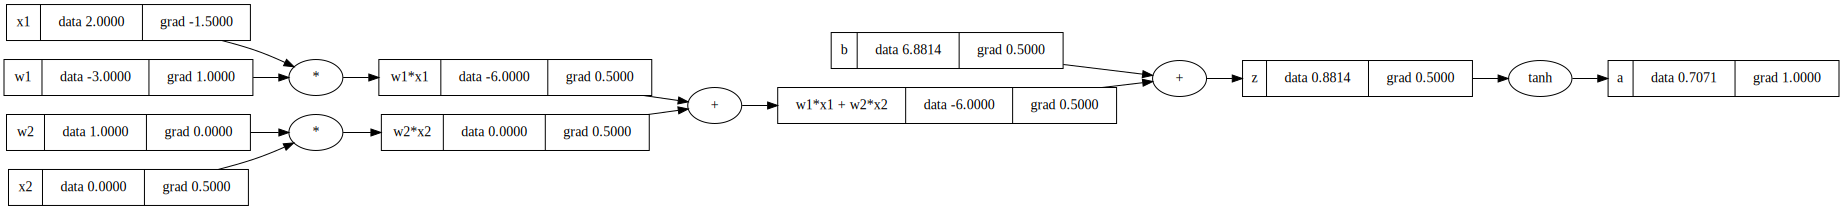

In [11]:
# a.grad = 1
# z.grad = 0.5
# b.grad = z.grad
# w1x1w2x2.grad = z.grad
# w1x1.grad = w1x1w2x2.grad
# w2x2.grad = w1x1w2x2.grad
# x1.grad = w1.data * w1x1.grad
# w1.grad = x1.data * w1x1.grad
# x2.grad = w2.data * w2x2.grad
# w2.grad = x2.data * w2x2.grad

# a.grad = 1
# build_topo(a)
# for node in topo:
#     print(node.label)

a.backward()
draw_dot(a)